<a href="https://colab.research.google.com/github/RDelg/rl-book/blob/master/chapter4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [0]:
class Env():
    _cache = dict()

    def __init__(
        self,
        lambda_request_a,
        lambda_in_a,
        lambda_request_b,
        lambda_in_b
        ):
        self.lambda_request_a = lambda_request_a
        self.lambda_in_a = lambda_in_a
        self.lambda_request_b = lambda_request_b
        self.lambda_in_b = lambda_in_b
        self.obs_space = self.ObsSpace()
        self.act_space = self.ActionSpace()
        self.reset()
  
    class ObsSpace:
        _space = [2]
        _min = 0
        _max = 20
  
    class ActionSpace:
        _space = [1]
        _min = -5
        _max = 5
    
    def move_dynamics(self):
        """
        Returns the matrix probability of terminating on each posible state
        given the current state. Each index value represent a combination of 
        the posible states.
        """
        obs_space_range = self.obs_space._max - self.obs_space._min + 1
        arrive_a = poisson.pmf(range(obs_space_range), self.lambda_request_a)
        left_a = poisson.pmf(range(obs_space_range), self.lambda_in_a)
        arrive_b = poisson.pmf(range(obs_space_range), self.lambda_request_b)
        left_b = poisson.pmf(range(obs_space_range), self.lambda_in_b)
        diff_prob_a = np.zeros(obs_space_range)
        for i in range(obs_space_range):
            diff = self.state[0] -i
            if diff < 0:
                diff_prob_a[i] = (arrive_a[abs(diff):] * left_a[:diff]).sum()
            elif diff == 0:
                diff_prob_a[i] = (arrive_a * left_a).sum()
            else:
                diff_prob_a[i] = (arrive_a[:-diff] * left_a[diff:]).sum()

        diff_prob_b = np.zeros(obs_space_range)
        
        for i in range(obs_space_range):
            diff = self.state[1] - i
            if diff < 0:
                diff_prob_b[i] = (arrive_b[abs(diff):] * left_b[:diff]).sum()
            elif diff == 0:
                diff_prob_b[i] = (arrive_b * left_b).sum()
            else:
                diff_prob_b[i] = (arrive_b[:-diff] * left_b[diff:]).sum()
        return diff_prob_a[:, None] * diff_prob_b[None, :]

    def reset(self):
        n = int(self.obs_space._max / 2)
        self.state = np.array([n, n])
  
    def _check_min_max(self, state):
        for i in range(2):
            if state[i] < self.obs_space._min:
                state[i] = self.obs_space._min
            elif state[i] > self.obs_space._max:
                state[i] = self.obs_space._max

    def set_state(self, state):
        assert len(state) == 2, 'state must be 2d'
        self.state = np.array(state)

    def _move_cars(self, n):
        self.state += np.array([-n , n])
        self._check_min_max(self.state)

    def reward_dynamics(self):
        """
        Returns the matrix reward from current state.
        Each index value represent a combination of the posible states.
        """
        a = np.zeros((self.state[0] + 1, self.state[1] + 1))
        with np.nditer(
            [a],
            flags=['multi_index'],
            op_flags=[['readwrite']]) as it:
            while not it.finished:
                it[0] = np.array(it.multi_index).sum()*10
                it.iternext()
        a = np.flip(np.flip(a, 1), 0)
        obs_space_range = self.obs_space._max - self.obs_space._min + 1
        reward_dynamics = np.zeros((obs_space_range, obs_space_range))
        reward_dynamics[:self.state[0]+1,:self.state[1]+1] = a
        return reward_dynamics
    
    def dynamics(self, action):
        reward = -2*np.abs(action)
        self._move_cars(action)
        if self._cache.get(tuple(self.state.ravel())) is None:
            self._cache[tuple(self.state.ravel())] = (self.move_dynamics(), (self.reward_dynamics() + reward))
        return self._cache.get(tuple(self.state.ravel()))

    def action(self, action):
        reward = -2*np.abs(action)
        self._move_cars(action)
        request_a = np.random.poisson(self.lambda_request_a)
        request_b = np.random.poisson(self.lambda_request_b)
        in_a = np.random.poisson(self.lambda_in_a)
        in_b = np.random.poisson(self.lambda_in_b)
        self.state += np.array([in_a, in_b])
        self._check_min_max(self.state)
        start_state = self.state.copy()
        self.state -= np.array([request_a, request_b])
        self._check_min_max(self.state)
        reward += np.sum(start_state - self.state)*10
        return self.state, reward

In [0]:
class PolicyLearner(object):
    def __init__(self, env, gamma=0.995):
        self.obs_space = env.obs_space
        self.act_space = env.act_space
        self.gamma = gamma
        self.env = env
        self.obs_space_range = self.obs_space._max - self.obs_space._min + 1
        self.action_space_range = self.act_space._max - self.act_space._min + 1
        self.action_probability = 1./self.action_space_range
        self.obs_space_shape = [
            self.obs_space_range for _ in range(self.obs_space._space[0])
        ]
        self.eps = 0.00001
        self.reset()

    def reset(self):
        self.value = np.zeros(shape=self.obs_space_shape)
        self.policy = np.zeros(shape=self.obs_space_shape, dtype=np.int32)

    def policy_evaluation(self):
        converged = False
        while not converged:
            old_value = self.value.copy()
            with np.nditer(
                [self.value, self.policy],
                flags=['multi_index'],
                op_flags=[['readwrite'],['readonly']]) as it:
                while not it.finished:
                    self.env.set_state(it.multi_index)
                    next_state_prob, reward_dist = self.env.dynamics(it[1])
                    new_value = 0.
                    with np.nditer(
                        [next_state_prob, reward_dist],
                        flags=['multi_index'],
                        op_flags=[['readonly'], ['readonly']]) as it2:
                        while not it2.finished:     
                            new_value += (
                                self.action_probability*np.float32(it2[0])*(
                                        np.float32(it2[1]) + 
                                        self.gamma*old_value[it2.multi_index]
                                    )
                                )
                            it2.iternext()
                    it[0][...] = new_value
                    it.iternext()
            delta = np.sum(np.abs(self.value - old_value))
            if delta < self.eps:
                converged = True

    def policy_improvement(self):
        stable = True
        with np.nditer(
            [self.policy],
            flags=['multi_index'],
            op_flags=[['readwrite']]) as it:
            while not it.finished:
                old_action = np.int32(it[0])
                q = np.zeros(self.action_space_range)
                for i in range(self.action_space_range):
                    action = i + self.act_space._min
                    self.env.set_state(it.multi_index)
                    next_state_prob, reward_dist = self.env.dynamics(action)
                    with np.nditer(
                        [next_state_prob, reward_dist],
                        flags=['multi_index'],
                        op_flags=[['readonly'], ['readonly']]) as it2:
                        while not it2.finished:     
                            q[i] += (
                                self.action_probability*np.float32(it2[0])*(
                                        np.float32(it2[1]) + 
                                        self.gamma*self.value[it2.multi_index]
                                    )
                                )
                            it2.iternext()
                it[0][...] = np.argmax(q) + self.act_space._min
                if np.int32(it[0]) != old_action:
                    stable = False
                it.iternext()
        return stable
    
    def plot_policy(self, ax=None, figsize=(6,6)):
        if ax is None:
            fig, ax = plt.subplots(figsize=figsize)
        img = np.flipud(self.policy)
        im = ax.imshow(img)
        # We want to show all ticks...
        ax.set_xticks(np.arange(self.obs_space_range))
        ax.set_yticks(np.flip(np.arange(self.obs_space_range)))

        ax.set_xticklabels(np.arange(self.obs_space_range))
        ax.set_yticklabels(np.arange(self.obs_space_range))

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        for i in range(self.obs_space_range):
            for j in range(self.obs_space_range):
                text = ax.text(j, i, img[i, j],
                            ha="center", va="center", color="w")

        ax.set_title("Policy")
    
    def plot_value(self, ax=None, figsize=(6,6)):
        if ax is None:
            fig, ax = plt.subplots(figsize=figsize)
            ax = fig.add_subplot(111, projection='3d')

        x = np.arange(self.obs_space_range)
        y = np.arange(self.obs_space_range)
        X, Y = np.meshgrid(x, y)
        ax.plot_surface(X, Y, self.value, cmap=cm.coolwarm)
        ax.set_xticks(np.arange(self.obs_space_range))
        ax.set_yticks(np.flip(np.arange(self.obs_space_range)))

        ax.set_xticklabels(np.arange(self.obs_space_range));
        ax.set_yticklabels(np.arange(self.obs_space_range));
        ax.set_title("Value")
    
    def plot(self, figsize=(12, 6)):
        fig = plt.figure(figsize=figsize)
        self.plot_policy(fig.add_subplot(121))
        self.plot_value(fig.add_subplot(122, projection='3d'))


In [0]:
env = Env(3,3,4,2)
learner = PolicyLearner(env)

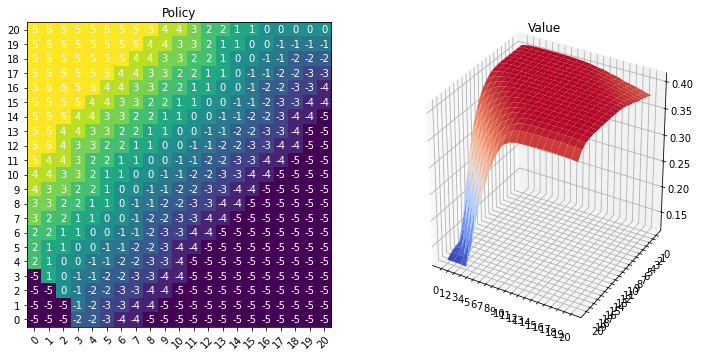

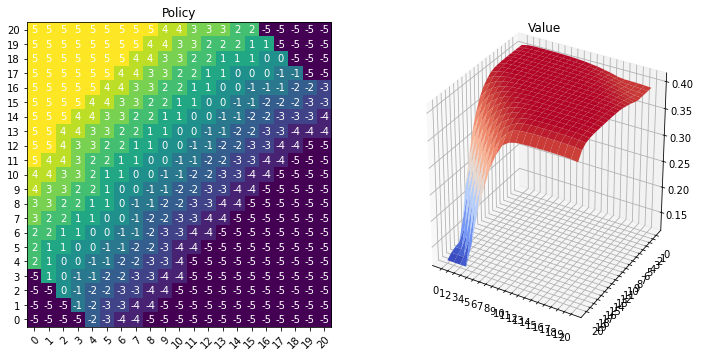

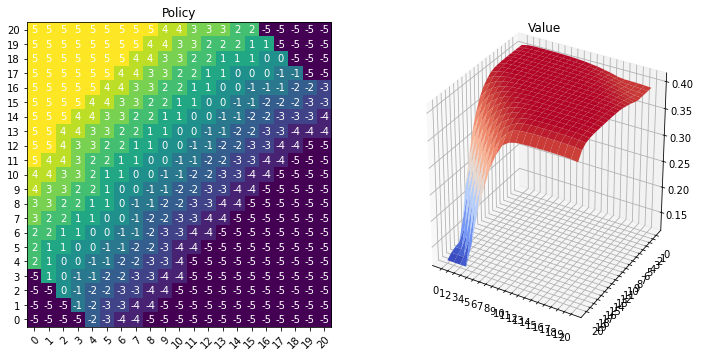

In [72]:
from tqdm.notebook import tqdm
for _ in tqdm(range(10)):
    
    stable = learner.policy_improvement()
    learner.policy_evaluation()
    learner.plot()
    if stable:
        break